# Perform single-cell quality control

In this notebook, we perform single-cell quality control. 
To filter the single-cells, we use z-score to find outliers using the values from only one feature at a time. 
We use features from the AreaShape and Intensity module to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Segmentation parameters, though optimized, does not mean it is perfect and will segment all nuclei "correctly".
When we say correctly, the basic definition we use is that a segmentation is around a nuclei and it is mostly accurate (can be slightly under or over segmented).
We are looking to identify technically "incorrect" segmentations, including clusters of nuclei, segmented background, multiple segmentation in one nuclei, etc.
To identify nuclei experiencing mis-segmentation, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. We detect nuclei that are abnormally large or small, which likely indicates poor nucleus segmentation.
- **Nuclei FormFactor:** This metric quantifies how circular an object is. The equation used is `4*π*Area/Perimeter^2`. The range of values are 0 to 1 where 1 means a perfect circle and 0 meaning a very odd shaped nuclei. We are looking to remove nuclei that have low `roundness` as we have found these nuclei have rough edges due to the algorithm struggling to segment.
- **Nuclei Eccentricity:** This metric quantifies how elongated an ellipse is. The range is 0 to 1 where 1 means it is a line shape and 0 is a circle. We are looking to remove nuclei that are very close to line shape as we have found these are related to mis-segmentations from mKate channel overlap into the Hoechst channel.
- **Nuclei Mean Intensity:** This metric quantifies the average intensity of the pixels in the nuclei segmentation when applied to the Hoechst channel. There is no specific range of values, but very small values likely indicate that a segmentation has been made around the background, which is not indicative of biology.

We use these features either in combination or alone when finding technical segmentation errors.
To be specific, we use:

| Measurement(s)               | Target                                                                                                          | Notes                                                                                                                                                          |
|------------------------------|-----------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Nuclei Area + FormFactor     | Small and large area that are very non-circular (small formfactor) | We use two combinations of this where one finds the non-circular small cells and the other non-circular large area.                                                                                                               |
| Nuclei Area + Intensity      | Small nuclei with low intensity within the segmentation (in the Hoechst channel) | This combination looks to find segmentations that are likely around background and not nuclei.                                                                                                              |
| Nuclei Eccentricity          | Segmentations that look like a straight line (too elongated) | We use this by itself since the poor segmentations can be any size when it is a mis-segmented straight line.                                                                                                         |


## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pathlib

import pandas as pd
import seaborn as sns

import cosmicqc as cosm
import matplotlib.colors as mcolors

/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


## Set paths and variables

In [2]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_sc_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc result CSV files
qc_results_dir = pathlib.Path("./qc_results")
qc_results_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Nuclei_Location_Center_X",
    "Nuclei_Location_Center_Y",
    "Image_FileName_DAPI"
]

# Get a list of the plates to be used for single-cell QC
plates = [plate.name.split("_")[0] for plate in data_dir.iterdir() if plate.is_dir()]

# Print the list of plates
print("These are plates identified:")
for plate in plates:
    print(plate)

These are plates identified:
slide3
slide2
slide1
slide4


## Concat all plates together to assess quality control

In [3]:
# Create an empty list to store data frames for each plate
all_plate_dfs = []

# Iterate through each plate and create the specified data frame
for plate in plates:
    # Only process the files that are in the plate names list
    plate_path = pathlib.Path(f"{data_dir}/{plate}/per_nuclei.parquet")

    # Read the parquet file into a DataFrame
    qc_df = pd.read_parquet(plate_path)

    # Append the data frame to the list
    all_plate_dfs.append(qc_df)

# Concatenate data frames for each plate
concat_df = pd.concat(all_plate_dfs)

# Reset the index so that the index doesn't reset per plate and cause issues downstream
concat_df.reset_index(drop=True, inplace=True)

print(concat_df.shape)
concat_df.head()

(248902, 585)


,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Image_Count_Nuclei,Image_FileName_DAPI,Nuclei_AreaShape_Area,Nuclei_AreaShape_BoundingBoxArea,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,...,Nuclei_Texture_Variance_A647_3_02_256,Nuclei_Texture_Variance_A647_3_03_256,Nuclei_Texture_Variance_DAPI_3_00_256,Nuclei_Texture_Variance_DAPI_3_01_256,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GOLD_3_00_256,Nuclei_Texture_Variance_GOLD_3_01_256,Nuclei_Texture_Variance_GOLD_3_02_256,Nuclei_Texture_Variance_GOLD_3_03_256
0,1,slide3,M14,A1,40,slide3_A1_M14_CH0_Z09_illumcorrect.tiff,1435.0,2496.0,465.0,104.0,...,0.000000,0.000000,23.186932,23.514296,23.214386,23.025264,0.000000,0.000000,0.000000,0.000000
1,1,slide3,M14,A1,40,slide3_A1_M14_CH0_Z09_illumcorrect.tiff,1267.0,4543.0,442.0,140.0,...,0.000000,0.000000,32.567225,32.401085,31.980568,35.163588,0.000000,0.000000,0.000000,0.000000
2,1,slide3,M14,A1,40,slide3_A1_M14_CH0_Z09_illumcorrect.tiff,2582.0,3776.0,256.0,1187.0,...,26.237975,26.620710,5.999356,6.049737,6.022163,5.708185,3.343330,3.348115,3.301296,3.341128
3,1,slide3,M14,A1,40,slide3_A1_M14_CH0_Z09_illumcorrect.tiff,1403.0,2499.0,214.0,1319.0,...,19.265605,18.742891,10.749099,10.821606,10.970465,10.659185,3.682435,3.704999,3.719122,3.639967
4,1,slide3,M14,A1,40,slide3_A1_M14_CH0_Z09_illumcorrect.tiff,1487.0,2912.0,267.0,1372.0,...,18.140014,18.313036,13.679695,14.215577,13.644427,13.971996,2.849506,2.872596,2.865991,2.845335


## Evaluate the distributions of the features across plates to determine best features to use for QC

/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

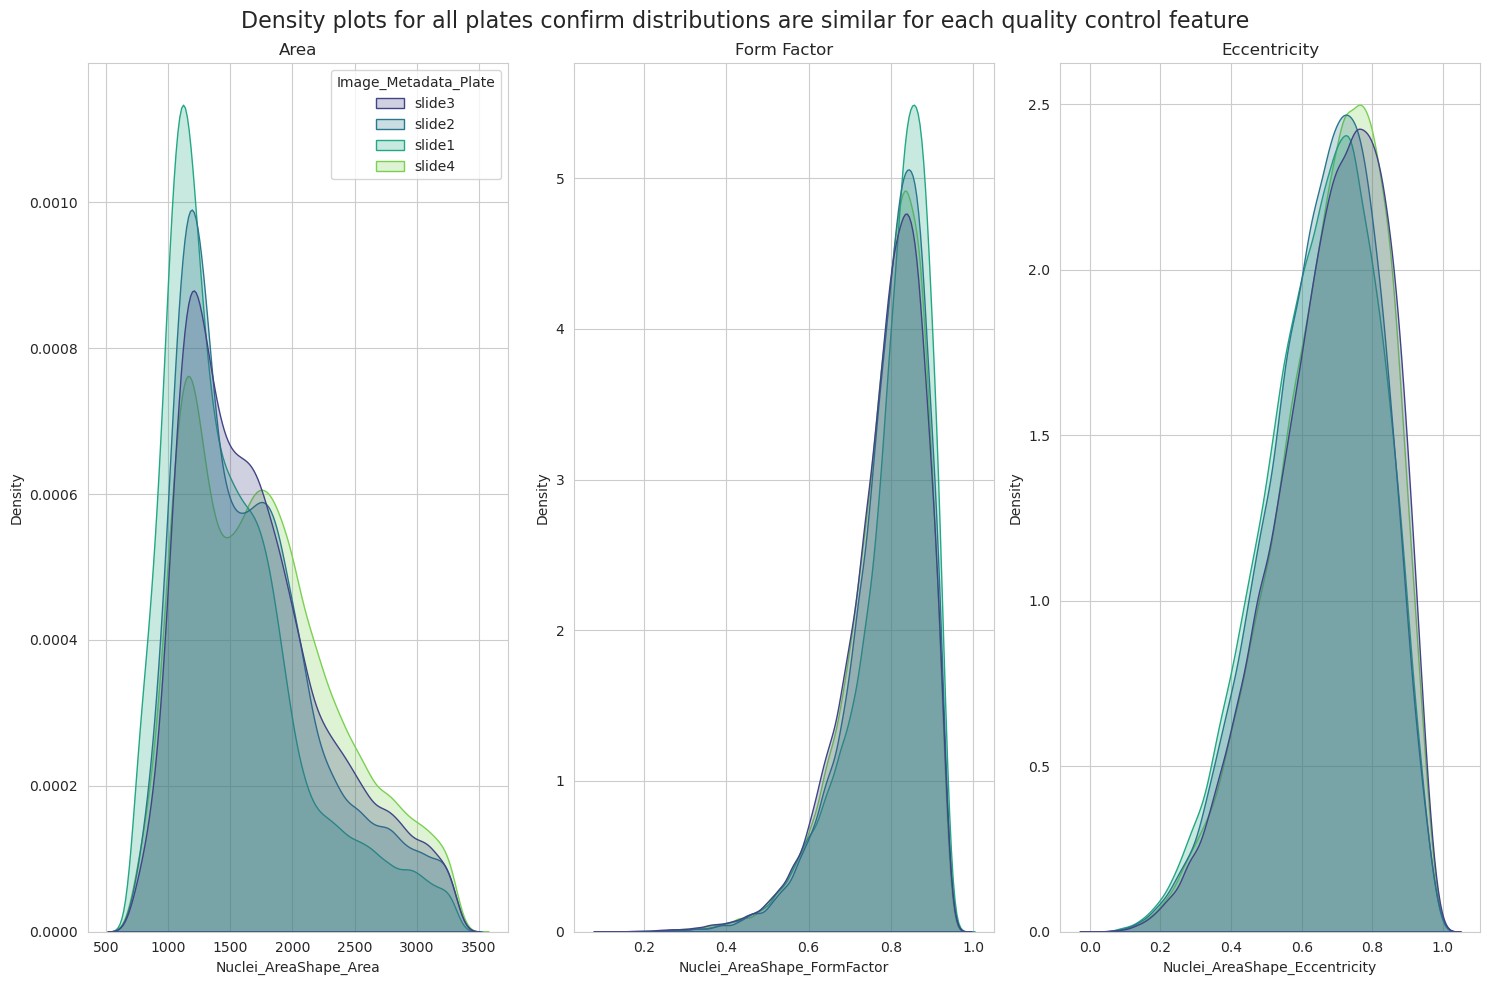

In [4]:
# Set the style
sns.set_style("whitegrid")

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create kdeplot for Nuclei_AreaShape_Area
sns.kdeplot(
    data=concat_df,
    x="Nuclei_AreaShape_Area",
    hue="Image_Metadata_Plate",
    palette="viridis",
    fill=True,
    common_norm=False,
    ax=axes[0],  # Set the first subplot
)
axes[0].set_title("Area")

# Create kdeplot for FormFactor
sns.kdeplot(
    data=concat_df,
    x="Nuclei_AreaShape_FormFactor",
    hue="Image_Metadata_Plate",
    palette="viridis",
    fill=True,
    common_norm=False,
    ax=axes[1],
    legend=False,
)
axes[1].set_title("Form Factor")

# Create kdeplot for Eccentricity
sns.kdeplot(
    data=concat_df,
    x="Nuclei_AreaShape_Eccentricity",
    hue="Image_Metadata_Plate",
    palette="viridis",
    fill=True,
    common_norm=False,
    ax=axes[2],
    legend=False,
)
axes[2].set_title("Eccentricity")

plt.suptitle(
    "Density plots for all plates confirm distributions are similar for each quality control feature",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1.0, 1.0])  # Adjust subplot layout

# Save figure
plt.savefig(
    pathlib.Path(f"{qc_fig_dir}/all_plates_QC_features_dist_plot.png"), dpi=500
)

plt.show()

## Use Nuclei Area and Nuclei FormFactor to determine nuclei that are small and improperly shaped due to mis-segmentation

In [5]:
# Set a negative threshold to identify both outlier small nuclei and low formfactor representing poor segmentations
outlier_threshold = -1

# find small nuclei and low intensity
feature_thresholds = {
    "Nuclei_AreaShape_Area": outlier_threshold,
    "Nuclei_AreaShape_FormFactor": outlier_threshold,
}

small_low_formfactor_outliers = cosm.find_outliers(
    df=concat_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

small_low_formfactor_outliers.sort_values(by="Nuclei_AreaShape_Area", ascending=True).head()

Number of outliers: 2108
Outliers Range:
Nuclei_AreaShape_Area Min: 707.0
Nuclei_AreaShape_Area Max: 1069.0
Nuclei_AreaShape_FormFactor Min: 0.11099356170941382
Nuclei_AreaShape_FormFactor Max: 0.6903040720071655


,Nuclei_AreaShape_Area,Nuclei_AreaShape_FormFactor,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Image_FileName_DAPI
221010,707.0,0.686755,slide4,B4,M18,1976.130127,1561.444130,slide4_B4_M18_CH0_Z09_illumcorrect.tiff
103711,707.0,0.612189,slide2,B4,M54,247.028289,620.267327,slide2_B4_M54_CH0_Z09_illumcorrect.tiff
13628,707.0,0.536934,slide3,A4,M23,54.574257,1234.048091,slide3_A4_M23_CH0_Z09_illumcorrect.tiff
104205,707.0,0.686755,slide2,B4,M55,1971.050919,1247.851485,slide2_B4_M55_CH0_Z09_illumcorrect.tiff
68364,708.0,0.681895,slide2,B2,M27,2121.690678,157.555085,slide2_B2_M27_CH0_Z09_illumcorrect.tiff


## Use Nuclei Area and Nuclei FormFactor to determine nuclei that are very large and improper segmentations where multiple nuclei are included in one segmentation

In [6]:
# find large nuclei segmentations (above mean) and low formfactor
feature_thresholds = {"Nuclei_AreaShape_Area": 2, "Nuclei_AreaShape_FormFactor": -1}

# run function to identify outliers given conditions
large_area_formfactor_outliers_df = cosm.find_outliers(
    df=concat_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

# print out data frame
large_area_formfactor_outliers_df.sort_values(by="Nuclei_AreaShape_Area", ascending=False).head()

Number of outliers: 5851
Outliers Range:
Nuclei_AreaShape_Area Min: 2815.0
Nuclei_AreaShape_Area Max: 3348.0
Nuclei_AreaShape_FormFactor Min: 0.20371813381262785
Nuclei_AreaShape_FormFactor Max: 0.6904288516004499


,Nuclei_AreaShape_Area,Nuclei_AreaShape_FormFactor,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Image_FileName_DAPI
120556,3348.0,0.586852,slide1,B1,M30,138.918160,1730.963560,slide1_B1_M30_CH0_Z09_illumcorrect.tiff
233765,3322.0,0.586928,slide4,B4,M3,2004.448224,991.667971,slide4_B4_M3_CH0_Z09_illumcorrect.tiff
24364,3321.0,0.630970,slide3,B3,M11,2077.632641,1196.989160,slide3_B3_M11_CH0_Z09_illumcorrect.tiff
71735,3320.0,0.631273,slide2,B3,M35,494.475602,1528.577108,slide2_B3_M35_CH0_Z09_illumcorrect.tiff
31791,3319.0,0.592481,slide3,B4,M14,451.724013,444.073516,slide3_B4_M14_CH0_Z09_illumcorrect.tiff


## Visualize the distribution of cells with Area and FormFactor

### Count

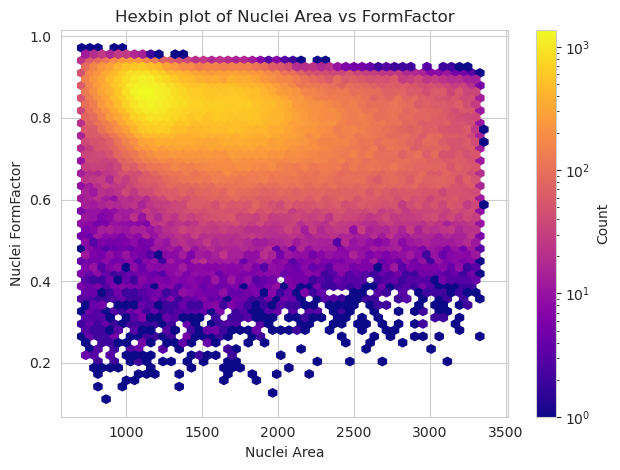

In [7]:
# Hexbin plot with Matplotlib to show the normalized log scale counts across Area and FormFactor
plt.hexbin(concat_df['Nuclei_AreaShape_Area'], concat_df['Nuclei_AreaShape_FormFactor'], gridsize=50, cmap='plasma', norm=mcolors.LogNorm())
plt.colorbar(label='Count')
plt.xlabel('Nuclei Area')
plt.ylabel('Nuclei FormFactor')
plt.title('Hexbin plot of Nuclei Area vs FormFactor')
plt.tight_layout()

# Save figure
plt.savefig(
    pathlib.Path(f"{qc_fig_dir}/nuclei_area_formfactor_count_hexbin.png"),
    dpi=500,
)

plt.show()

### Outlier status

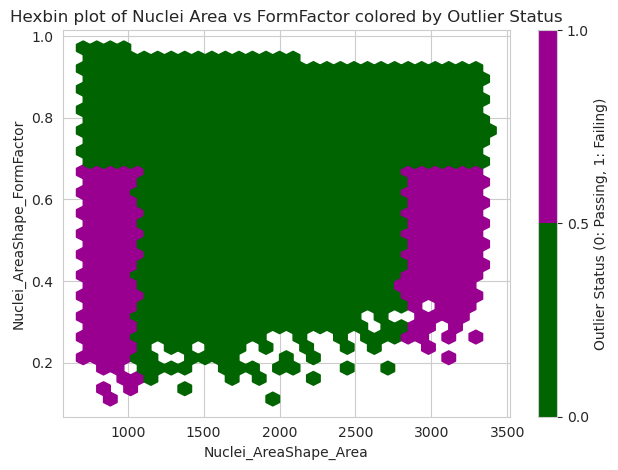

In [8]:
# Reset the default value to 'inlier'
concat_df["Outlier_Status"] = 0

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
concat_df.loc[concat_df.index.isin(small_low_formfactor_outliers.index), "Outlier_Status"] = (
    1
)

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
concat_df.loc[concat_df.index.isin(large_area_formfactor_outliers_df.index), "Outlier_Status"] = (
    1
)
# Ensure 'Outlier_Status' is numeric
concat_df['Outlier_Status'] = pd.to_numeric(concat_df['Outlier_Status'], errors='coerce')

# Define a custom colormap
cmap = mcolors.ListedColormap(['#006400', '#990090'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create hexbin plot with custom color mapping
hb = plt.hexbin(concat_df['Nuclei_AreaShape_Area'], concat_df['Nuclei_AreaShape_FormFactor'],
                C=concat_df['Outlier_Status'], gridsize=30, cmap=cmap, norm=norm)

plt.colorbar(hb, label='Outlier Status (0: Passing, 1: Failing)')
plt.xlabel('Nuclei_AreaShape_Area')
plt.ylabel('Nuclei_AreaShape_FormFactor')
plt.title('Hexbin plot of Nuclei Area vs FormFactor colored by Outlier Status')
plt.tight_layout()

# Save figure
plt.savefig(
    pathlib.Path(f"{qc_fig_dir}/nuclei_area_formfactor_outlier_status_hexbin.png"),
    dpi=500,
)

plt.show()

## Use Nuclei Eccentricity to identify nuclei that are very long due to mis-segmentations

In [9]:
# find very elongated nuclei segmentations (above mean)
feature_thresholds = {
    "Nuclei_AreaShape_Eccentricity": 2,
}

# run function to identify outliers given conditions
eccent_outliers_df = cosm.find_outliers(
    df=concat_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

# print out data frame
eccent_outliers_df.head()

Number of outliers: 36
Outliers Range:
Nuclei_AreaShape_Eccentricity Min: 0.9901352931491393
Nuclei_AreaShape_Eccentricity Max: 0.996925508482783


,Nuclei_AreaShape_Eccentricity,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Image_FileName_DAPI
8459,0.996411,slide3,A2,M61,1732.340340,1752.661662,slide3_A2_M61_CH0_Z09_illumcorrect.tiff
12322,0.992846,slide3,A3,M6,1461.445532,1612.198956,slide3_A3_M6_CH0_Z09_illumcorrect.tiff
12325,0.992090,slide3,A3,M6,1665.479576,1688.462330,slide3_A3_M6_CH0_Z09_illumcorrect.tiff
14810,0.993719,slide3,A4,M37,1149.613150,1401.450051,slide3_A4_M37_CH0_Z09_illumcorrect.tiff
19324,0.996926,slide3,B1,M52,1208.751105,196.790869,slide3_B1_M52_CH0_Z09_illumcorrect.tiff


### Visualize eccentricity outliers specifically in a histogram prior to merging all outliers together

/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

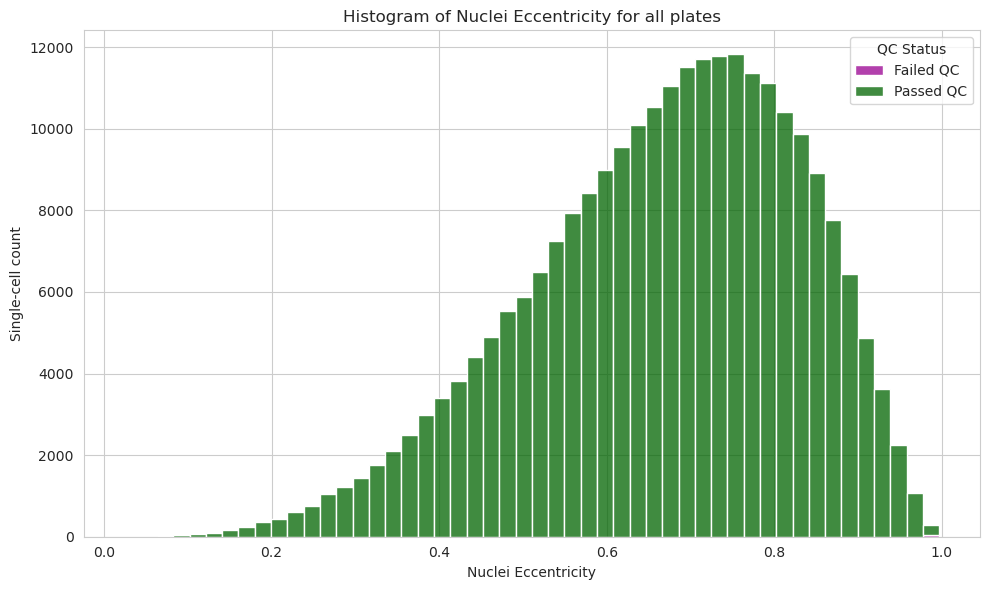

In [10]:
# Reset the default value to 'inlier'
concat_df["Outlier_Status"] = "Single-cell passed QC"

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
concat_df.loc[concat_df.index.isin(eccent_outliers_df.index), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=concat_df,
    x="Nuclei_AreaShape_Eccentricity",
    hue="Outlier_Status",
    multiple="stack",
    bins=50,  # Adjust the number of bins as needed
    palette={"Single-cell passed QC": "#006400", "Single-cell failed QC": "#990090"},
    legend=True,
)

plt.title(f"Histogram of Nuclei Eccentricity for all plates")
plt.xlabel("Nuclei Eccentricity")
plt.ylabel("Single-cell count")
plt.tight_layout()

# Show the legend
plt.legend(
    title="QC Status",
    loc="upper right",
    prop={"size": 10},
    labels=["Failed QC", "Passed QC"],
)

# Save figure
plt.savefig(
    pathlib.Path(f"{qc_fig_dir}/nuclei_eccentricity_histogram.png"),
    dpi=500,
)

plt.show()

## Combine all combinations of outlier data frames together to make one nuclei outlier data frame

### Concat on common columns to make one nuclei outlier data frame

In [11]:
# Concat all outlier data frames together on common columns to make one nuclei outliers data frame
common_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Nuclei_Location_Center_X",
    "Nuclei_Location_Center_Y",
]

nuclei_outliers_df = pd.concat(
    [
        small_low_formfactor_outliers[common_columns],
        large_area_formfactor_outliers_df[common_columns],
        eccent_outliers_df[common_columns],
    ]
)

# Define column names to be added
columns_to_add = [
    "Small_Area_FormFactor_Failed",
    "Large_Area_FormFactor_Failed",
    "Eccentricity_Failed",
]

# Iterate over each column name
for column_name in columns_to_add:
    # Assign 1 to rows where the column exists in the corresponding dataframe, else 0
    nuclei_outliers_df[column_name] = 0
    nuclei_outliers_df.loc[
        nuclei_outliers_df.index.isin(small_low_formfactor_outliers.index)
        & (column_name == "Small_Area_FormFactor_Failed"),
        column_name,
    ] = 1
    nuclei_outliers_df.loc[
        nuclei_outliers_df.index.isin(large_area_formfactor_outliers_df.index)
        & (column_name == "Large_Area_FormFactor_Failed"),
        column_name,
    ] = 1
    nuclei_outliers_df.loc[
        nuclei_outliers_df.index.isin(eccent_outliers_df.index)
        & (column_name == "Eccentricity_Failed"),
        column_name,
    ] = 1

# drop any duplicates based on index
nuclei_outliers_df = nuclei_outliers_df.drop_duplicates(subset=None)

print(nuclei_outliers_df.shape)
nuclei_outliers_df.head()

(7982, 8)


,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Small_Area_FormFactor_Failed,Large_Area_FormFactor_Failed,Eccentricity_Failed
18,slide3,A1,M14,2027.516443,1889.803898,1,0,0
19,slide3,A1,M14,239.049088,1892.262272,1,0,0
31,slide3,A1,M14,1885.584440,2014.648008,1,0,0
101,slide3,A1,M16,1704.163265,144.226891,1,0,0
105,slide3,A1,M16,694.888889,1311.938272,1,0,0


### Plot a histogram of the number of cells detected across conditions

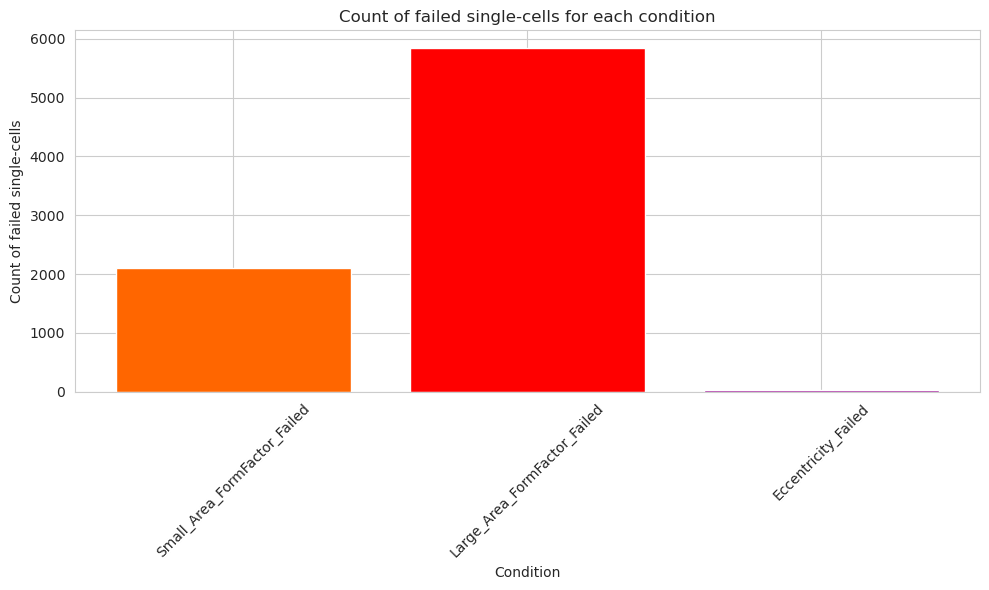

In [12]:
# Define the palette
palette = {
    "Small_Area_FormFactor_Failed": "#ff6600",
    "Large_Area_FormFactor_Failed": "#ff0000",
    "Eccentricity_Failed": "#990090",
}

# Count the number failing cells in each condition
column_counts = nuclei_outliers_df[columns_to_add].sum()

# Get the colors from the palette corresponding to each condition
colors = [palette.get(condition, "skyblue") for condition in column_counts.index]

# Plot histogram with colors matching the conditions
plt.figure(figsize=(10, 6))
plt.bar(column_counts.index, column_counts.values, color=colors)  # Use colors here
plt.title("Count of failed single-cells for each condition")
plt.xlabel("Condition")
plt.ylabel("Count of failed single-cells")
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig(
    pathlib.Path(f"{qc_fig_dir}/qc_conditions_sc_count_histogram.png"),
    dpi=500,
)

plt.show()

## Output data frame to go over examples of passing or failing single-cells

In [13]:
concat_df[
    [
        "Outlier_Status",
        "Nuclei_AreaShape_Area",
        "Nuclei_AreaShape_FormFactor",
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Nuclei_Location_Center_X",
        "Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_Area", ascending=False).head()

,Outlier_Status,Nuclei_AreaShape_Area,Nuclei_AreaShape_FormFactor,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Nuclei_Location_Center_X,Nuclei_Location_Center_Y
220130,Single-cell passed QC,3382.0,0.776585,slide4,B4,M15,199.162034,1621.438794
116472,Single-cell passed QC,3356.0,0.743222,slide1,A3,M43,548.119785,124.949046
120556,Single-cell passed QC,3348.0,0.586852,slide1,B1,M30,138.918160,1730.963560
192720,Single-cell passed QC,3325.0,0.723290,slide4,A3,M44,731.511880,700.431880
233765,Single-cell passed QC,3322.0,0.586928,slide4,B4,M3,2004.448224,991.667971


## Remove any single-cell that was identified as failing QC and save cleaned data per plate

### Remove single-cells identified as failing QC from the dataset

In [14]:
# Identify failing QC single-cells based on index values
outlier_indices = nuclei_outliers_df.index

# Remove rows with outlier indices (identified above) from the concat data frame
concat_df_cleaned = concat_df.drop(outlier_indices)

# Remove columns from z-scoring or assigning outliers (not included for downstream analysis)
columns_to_keep = [
    col
    for col in concat_df_cleaned.columns
    if not col.startswith("Z_Score") and col != "Outlier_Status"
]

# Filter columns based on conditions
concat_df_cleaned = concat_df_cleaned[columns_to_keep]

# Get the number of indices removed during cleaning
num_indices_removed = len(concat_df.index) - len(concat_df_cleaned.index)

# Save cleaned data for each plate and show the number of single-cells removed per plate
for plate, plate_df in concat_df_cleaned.groupby("Image_Metadata_Plate"):
    num_removed_per_plate = len(
        concat_df[concat_df["Image_Metadata_Plate"] == plate]
    ) - len(plate_df)
    plate_df.to_parquet(f"{cleaned_dir}/{plate}_sc_cleaned.parquet")
    print(f"Plate {plate}: Number of single-cells dropped: {num_removed_per_plate}")

# Verify the result
print(f"Number of single-cells dropped: {num_indices_removed}")
print(plate_df.shape)
plate_df.head()

Plate slide1: Number of single-cells dropped: 2307
Plate slide2: Number of single-cells dropped: 1716
Plate slide3: Number of single-cells dropped: 1967
Plate slide4: Number of single-cells dropped: 1992
Number of single-cells dropped: 7982
(63359, 585)


,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Image_Count_Nuclei,Image_FileName_DAPI,Nuclei_AreaShape_Area,Nuclei_AreaShape_BoundingBoxArea,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,...,Nuclei_Texture_Variance_A647_3_02_256,Nuclei_Texture_Variance_A647_3_03_256,Nuclei_Texture_Variance_DAPI_3_00_256,Nuclei_Texture_Variance_DAPI_3_01_256,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GOLD_3_00_256,Nuclei_Texture_Variance_GOLD_3_01_256,Nuclei_Texture_Variance_GOLD_3_02_256,Nuclei_Texture_Variance_GOLD_3_03_256
183551,1,slide4,M10,A1,77,slide4_A1_M10_CH0_Z09_illumcorrect.tiff,2275.0,3216.0,400.0,75.0,...,10.789904,10.996681,10.213516,10.139411,10.001779,10.155216,4.681323,4.630844,4.579536,4.667291
183552,1,slide4,M10,A1,77,slide4_A1_M10_CH0_Z09_illumcorrect.tiff,1464.0,2496.0,1054.0,125.0,...,17.474115,17.093638,0.533158,0.544947,0.543148,0.543609,5.462323,5.517105,5.507966,5.355558
183553,1,slide4,M10,A1,77,slide4_A1_M10_CH0_Z09_illumcorrect.tiff,1736.0,2438.0,1421.0,180.0,...,21.290511,20.989249,4.208639,4.212363,4.118850,4.224876,6.057939,6.074450,6.246712,5.981124
183554,1,slide4,M10,A1,77,slide4_A1_M10_CH0_Z09_illumcorrect.tiff,1267.0,2546.0,1488.0,161.0,...,18.992269,18.194607,6.158843,6.128042,6.356093,6.452785,10.499313,10.555566,10.940426,10.607531
183555,1,slide4,M10,A1,77,slide4_A1_M10_CH0_Z09_illumcorrect.tiff,1247.0,1860.0,419.0,144.0,...,43.385094,44.568524,21.345136,21.660066,22.201572,21.704614,21.645153,21.847623,21.758872,22.016405
